# Squeeze Every Ounce of Performance

## Table of Contents
1. [Importing Essential Libraries](#import)
2. [Loading the Data](#load)

<a id='import'></a>
## 1. [Importing Essential Libraries](#toc)
`The Sumerians invented the wheel. I'd much rather just use it.`

In [ ]:
import numpy as np
import requests
import tarfile
import tensorflow as tf
import os
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id='load'></a>
## 2. [Loading the Data](#toc)
`A machine learning model is only as good as its data`

In [ ]:
def download_data():
    """
    Function to download the data
    Arguments:
    None
    Returns:
    None
    """
    url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    response = requests.get(url, stream = True)
    file = tarfile.open(fileobj=response.raw, mode="r|gz")
    file.extractall(path = '/content/drive/MyDrive/Squeezenet Implementation/Data')
    return

# download_data()

In [ ]:
def load_data():
    """
    Loads data and corresponding labels to numpy arrays and returns the image and labelled data
    Arguments:
    None
    Returns:
    1) Images reshaped into the appropriate shape
    2) Labels corresponding to the images in order
    """
    datapath = '/content/drive/MyDrive/Squeezenet Implementation/Data/cifar-10-batches-py'
    
    # Training data:-
    training_datasets = [file for file in list(os.listdir(datapath)) if file.startswith('data_batch')]
    training_images = np.empty((0, 3, 32, 32), 'uint8')
    training_labels = np.empty((0), 'int32')
    for file in training_datasets:
        data = pickle.load(open(os.path.join(datapath, file), 'rb'), encoding = 'bytes')
        training_images = np.append(training_images, np.array(data[b'data']).reshape(-1, 3, 32,32), 0)
        training_labels = np.append(training_labels, np.array(data[b'labels']), 0)
    
    # Test data:-
    test_datasets = [file for file in list(os.listdir(datapath)) if file.startswith('test_batch')]
    test_images = np.empty((0, 3, 32, 32), 'uint8')
    test_labels = np.empty((0), 'int32')
    for file in test_datasets:
        data = pickle.load(open(os.path.join(datapath, file), 'rb'), encoding = 'bytes')
        test_images = np.append(test_images, np.array(data[b'data']).reshape(-1, 3, 32,32), 0)
        test_labels = np.append(test_labels, np.array(data[b'labels']), 0)
    
    return training_images, training_labels, test_images, test_labels

training_images, training_labels, test_images, test_labels = load_data()
label_mapping = ['airplane', 'automobile','bird','cat', 'deer', 'dog','frog', 'horse', 'ship', 'truck']

## 3. [Examining Data](#toc)
`A correct diagnosis is three-fourths the remedy`

In [ ]:
print(f'Number of unique pixel values in the training set:{len(np.unique(training_images.reshape((training_images.shape[0], -1))))}')
print(f'Number of unique pixel values in the test set:{len(np.unique(test_images.reshape((test_images.shape[0], -1))))}')
print(f'Number of unique labels in training set:{len(np.unique(training_labels))}\nNumber of unique labels in test set:{len(np.unique(test_labels))}')

Number of unique pixel values in the training set:256
Number of unique pixel values in the test set:256
Number of unique labels in training set:10
Number of unique labels in test set:10


In [ ]:
print(f'Shape of training data: {training_images.shape}')
print(f'Shape of training labels: {training_labels.shape}')
print(f'Shape of test data: {test_images.shape}')
print(f'Shape of test labels: {test_labels.shape}')

print('-'*100)

training_images = np.swapaxes(training_images, 1,3)
test_images = np.swapaxes(test_images, 1,3)
training_images = np.swapaxes(training_images, 1,2)
test_images = np.swapaxes(test_images, 1,2)

print(f'New shape of training data: {training_images.shape}')
print(f'New shape of training labels: {training_labels.shape}')
print(f'New shape of test data: {test_images.shape}')
print(f'New shape of test labels: {test_labels.shape}')

Shape of training data: (50000, 3, 32, 32)
Shape of training labels: (50000,)
Shape of test data: (10000, 3, 32, 32)
Shape of test labels: (10000,)
----------------------------------------------------------------------------------------------------
New shape of training data: (50000, 32, 32, 3)
New shape of training labels: (50000,)
New shape of test data: (10000, 32, 32, 3)
New shape of test labels: (10000,)


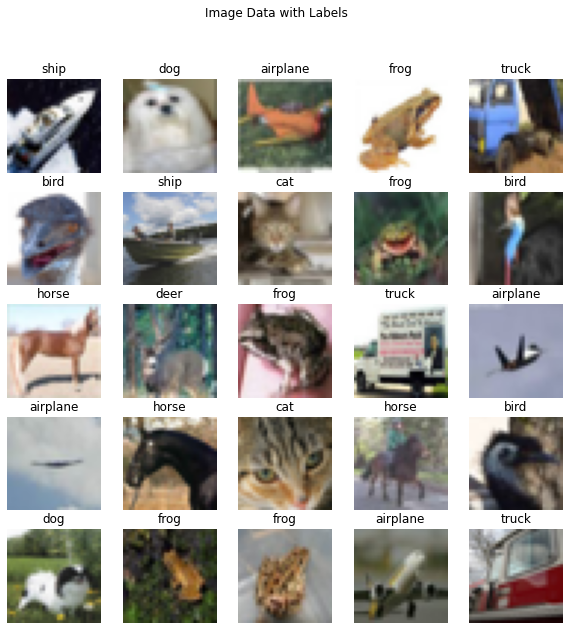

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.axis('off')
    plt.title(label_mapping[training_labels[i]])
    plt.imshow(training_images[i])
    
_ = plt.suptitle("Image Data with Labels")

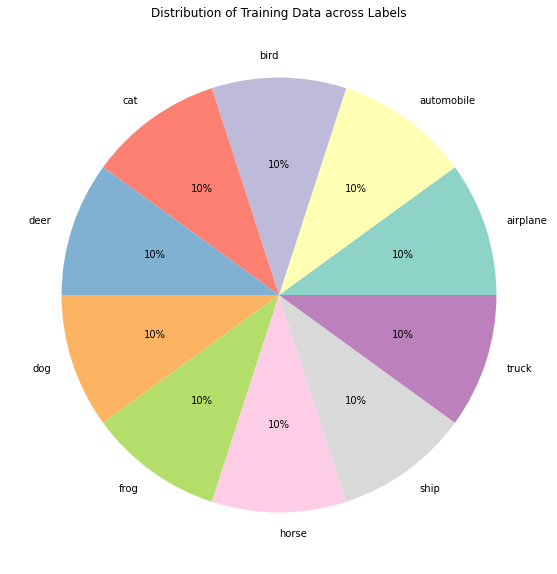

In [ ]:
def count_occurences(training_labels):
    """
    """
    labels, counts = np.unique(training_labels, return_counts = True)
    return dict(zip(labels, counts))

sns.set_palette("Set3")
count_labels = count_occurences(training_labels)
plt.figure(figsize = (20,10))
plt.title("Distribution of Training Data across Labels")
plt.pie(list(count_labels.values()), labels = [label_mapping[i] for i in count_labels.keys()], autopct='%.0f%%');

The dataset is already balanced! We can move to the next segment of the assignment - namely designing an appropriate model for the dataset.

In [ ]:
# Conversion to tf.data.Dataset objects
one_hot_training_labels = tf.keras.utils.to_categorical(training_labels)
one_hot_test_labels = tf.keras.utils.to_categorical(test_labels)
train_ds = tf.data.Dataset.from_tensor_slices((training_images, one_hot_training_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, one_hot_test_labels))

In [ ]:
train_examples = tf.data.experimental.cardinality(train_ds)
val_ds = train_ds.take(train_examples//5)
training_ds = train_ds.skip(train_examples//5)

## 4. Shuffle Data
`If the cards are stacked against you, shuffle the deck.`

In [ ]:
BUFFER_SIZE = 100

train_dataset = training_ds.shuffle(BUFFER_SIZE)
val_dataset = val_ds.shuffle(BUFFER_SIZE)
test_dataset = test_ds.shuffle(BUFFER_SIZE)

## 5. Choose Mini-Batch Size
`Even God took 6 days to create our world. Small but sure steps can take you far.`

In [ ]:
def batch_and_prefetch(dataset, batch_size):
    """
    Splits input data into minibatches of specified size and prefetches it
    Arguments:
    1) Data
    2) Mini-batch size
    Returns:
    1) Dataset with mini-batches
    """
    return dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

BATCH_SIZE = 64
train_dataset = batch_and_prefetch(train_dataset, BATCH_SIZE)
val_dataset = batch_and_prefetch(val_dataset, BATCH_SIZE)
test_dataset = batch_and_prefetch(test_dataset, BATCH_SIZE)

In [ ]:
batch = ()
for image_batch, label_batch in train_dataset.take(1):
    batch = image_batch

input_shape = batch[0].shape
print(input_shape)

train_dataset

(32, 32, 3)


<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.uint8, tf.float32)>

## 6. Define the Model
`I see you`

In [ ]:
def fire_module(x, s1, e1, e3, depth):
  """
  Implements the definition of the fire module in the squeezenet network
  Arguments:
  1) Input data
  2) Number of channels in the squeeze layer
  3) Number of channels in the 1x1 expand layer
  4) Number of channels in the 3x3 expand layer
  5) Depth of the layer
  Returns:
  1) Output data
  """
  x = tf.keras.layers.Conv2D(s1, kernel_size = 1, padding = 'same', name = f'squeeze_layer_{depth+1}')(x)
  x = tf.keras.layers.BatchNormalization(name = f'bn_post_squeeze_{depth+1}')(x)
  out_1 = tf.keras.layers.Conv2D(e1, kernel_size = 1, padding = 'same', name = f'expand_layer_kernel1_{depth+1}')(x)
  out_1 = tf.keras.layers.BatchNormalization(name = f'bn_post_1x1_expand_{depth+1}')(out_1)
  out_2 = tf.keras.layers.Conv2D(e3, kernel_size = 3, padding = 'same', name = f'expand_layer_kernel3_{depth+1}')(x)
  out_2 = tf.keras.layers.BatchNormalization(name = f'bn_post_3x3_expand_{depth+1}')(out_2)
  x = tf.keras.layers.concatenate([out_1, out_2], name = f'concatenate_layer_{depth+1}')
  return x

Now we can't exactly replicate the squeezenet architecture as it is because the input size was much larger (224x224x3). However, what we can do is that we can use the fire module to design a smaller network that reflects the squeezenet design principles.

In [ ]:
def squeezenet_model_def(inp_shape, 
                         num_classes = 10,
                         channels_squeeze_fire = [16, 32, 48, 64],
                         channels_expand_fire = [128, 256, 384, 512]):
  """
  """
  assert len(channels_squeeze_fire) == len(channels_expand_fire)
  assert len(channels_squeeze_fire) > 2
  inp = tf.keras.layers.Input(shape=inp_shape, name = 'input_layer')
  x= inp
  x = tf.keras.layers.Rescaling(scale = 1./255, name = 'rescaling_layer')(x)
  x = tf.keras.layers.Conv2D(96, kernel_size = (3,3), padding = 'same', name = 'conv_layer_1')(x)
  x = tf.keras.layers.BatchNormalization(name='bn_post_conv_layer_1')(x)
  x = tf.keras.layers.MaxPool2D(strides = (2,2), name = 'maxpool_layer_initial')(x)
  flag = 0
  for i in range(len(channels_squeeze_fire)):
    if int(len(channels_squeeze_fire)//2) == i and flag == 0:
      x = tf.keras.layers.MaxPool2D(strides = (2,2), name = 'maxpool_layer_1')(x)
      flag = 1
    if len(channels_squeeze_fire) - 2 == i:
      x = tf.keras.layers.MaxPool2D(strides = (2,2), name = 'maxpool_layer_2')(x)
      pass
    x = fire_module(x,
                    s1 = channels_squeeze_fire[i],
                    e1 = channels_expand_fire[i]//2,
                    e3 = channels_expand_fire[i]//2,
                    depth = i)
  
  x = tf.keras.layers.Dropout(0.5, name = 'dropout_layer')(x)
  x = tf.keras.layers.Conv2D(num_classes, kernel_size = 1, name = 'conv_layer_final')(x)
  x = tf.keras.layers.BatchNormalization(name='bn_post_conv_layer_final')(x)
  x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_pooling_layer')(x)
  out = tf.keras.layers.Softmax(name='classification_layer')(x)
  model = tf.keras.models.Model(inp, out)
  return model

In [ ]:
squeezenet_model = squeezenet_model_def(inp_shape = input_shape,
                                        channels_squeeze_fire = [16,16,32,32,48,48,64,64],
                                        channels_expand_fire = [128,128,256,256,384,384,512,512])

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 0.1
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

squeezenet_model.compile(optimizer = optimizer,
                         loss = loss,
                         metrics = ['accuracy'])

In [ ]:
squeezenet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_layer (Rescaling)    (None, 32, 32, 3)    0           ['input_layer[0][0]']            
                                                                                                  
 conv_layer_1 (Conv2D)          (None, 32, 32, 96)   2688        ['rescaling_layer[0][0]']        
                                                                                                  
 bn_post_conv_layer_1 (BatchNor  (None, 32, 32, 96)  384         ['conv_layer_1[0][0]']           
 malization)                                                                                

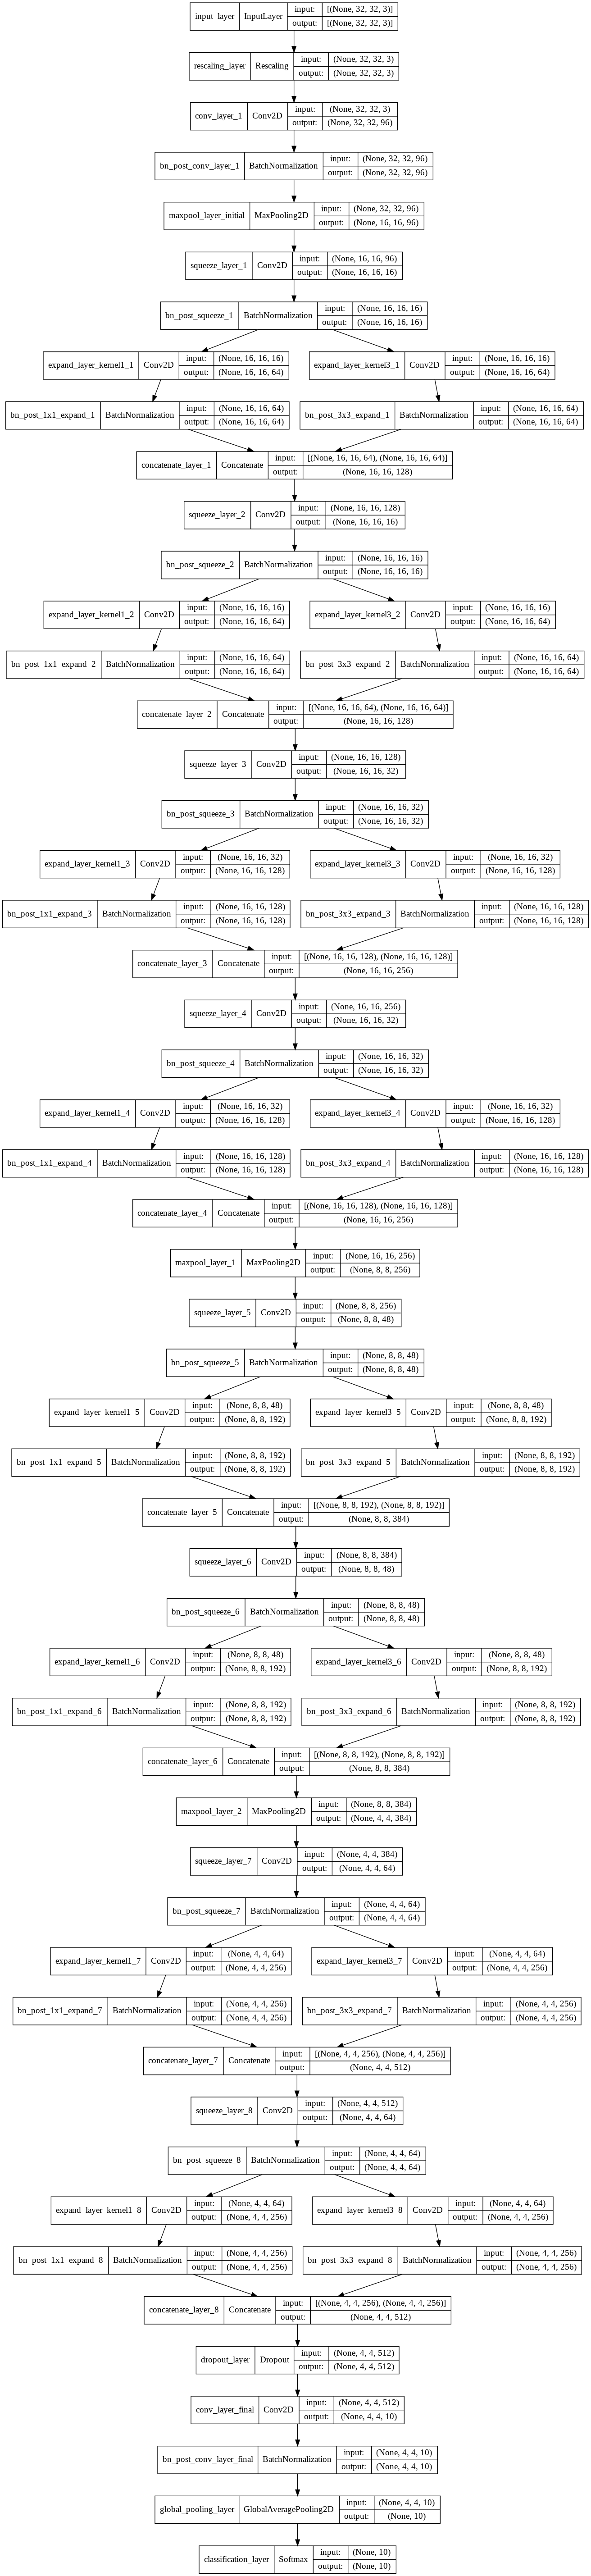

In [ ]:
tf.keras.utils.plot_model(squeezenet_model,show_shapes = True)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Squeezenet Implementation/Training_Checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_prefix,
                                                        save_weights_only = True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=1, min_lr=1e-9)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='min', restore_best_weights=True)

EPOCHS = 50
history = squeezenet_model.fit(train_dataset,
                               epochs = EPOCHS,
                               callbacks = [reduce_lr,
                                            early_stop,
                                            checkpoint_callback])

Epoch 1/50
625/625 [==============================] - 17s 23ms/step - loss: 1.8023 - accuracy: 0.3244 - lr: 0.1000
Epoch 2/50
625/625 [==============================] - 14s 23ms/step - loss: 1.5536 - accuracy: 0.4377 - lr: 0.1000
Epoch 3/50
625/625 [==============================] - 15s 23ms/step - loss: 1.4479 - accuracy: 0.4793 - lr: 0.1000
Epoch 4/50
625/625 [==============================] - 14s 23ms/step - loss: 1.3722 - accuracy: 0.5094 - lr: 0.1000
Epoch 5/50
625/625 [==============================] - 15s 23ms/step - loss: 1.2924 - accuracy: 0.5379 - lr: 0.1000
Epoch 6/50
625/625 [==============================] - 14s 23ms/step - loss: 1.2340 - accuracy: 0.5624 - lr: 0.1000
Epoch 7/50
625/625 [==============================] - 14s 23ms/step - loss: 1.1846 - accuracy: 0.5800 - lr: 0.1000
Epoch 8/50
625/625 [==============================] - 14s 23ms/step - loss: 1.1426 - accuracy: 0.5955 - lr: 0.1000
Epoch 9/50
625/625 [==============================] - 14s 23ms/step - loss: 1.10